<a href="https://colab.research.google.com/github/M-ballabio1/DataScience_ML_DL-projects/blob/main/DeepLearning%20Projects/5.%20NN_classification_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN - Electrocardiogram time series classification

**Obiettivo**:

L'obiettivo di questo notebook è classificare delle serie temporali, in particolare segnali ECG, in queste 5 categorie [N:0, S:1, V:2 , F:3, Q:4]:

N: Normal Beats

S: Superventrical Beats

V: Ventricular Beats

F: Fusion Beats

Q: Unknown Beats

**Dataset**

*Background:*

Dal 1975, i laboratori al Beth Israel Hospital di Boston e al MIT hanno supportato la nostra ricerca sull'analisi dell'aritmia e argomenti correlati. Uno dei primi prodotti importanti di tale sforzo è stato il MIT-BIH Arrhythmia Database, che è stato distribuito dal 1980.

*Descrizione dei dati*

Il MIT-BIH Arrhythmia Database contiene 48 estratti di mezz'ora di registrazioni ECG ambulatoriali a due canali, ottenute da 47 soggetti studiati dal BIH Arrhythmia Laboratory tra il 1975 e il 1979.

*Informazioni riassuntive:*

Numero di campioni: 109446

Numero di categorie: 5

Frequenza di campionamento: 125 Hz

Fonte dei dati: set di dati sull'aritmia MIT-BIH di Physionet


In [17]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# tensorflow libraries
from tensorflow.python.keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# scikit libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [2]:
data_train= pd.read_csv("/content/drive/MyDrive/ECG_Classification/mitbih_train.csv")
data_train.iloc[:,-1].value_counts()

0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 0.000000000000000000e+00.88, dtype: int64

In [3]:
data_test= pd.read_csv("/content/drive/MyDrive/ECG_Classification/mitbih_test.csv")
data_test.iloc[:,-1].value_counts()

0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 0.000000000000000000e+00.65, dtype: int64

In [4]:
## splitting dataset
x_train = data_train.iloc[:,0:187]
y_train= data_train.iloc[:,-1]
x_test= data_test.iloc[:,0:187]
y_test= data_test.iloc[:,-1]

### Exploratory analysis

Esempio plot un tracciato ECG del paziente 5

In [34]:
lst = list(range(1,187+1))
degrees = 90

([<matplotlib.axis.XTick at 0x7f0bae042d10>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10'),
  Text(0, 0, '11'),
  Text(0, 0, '12'),
  Text(0, 0, '13'),
  Text(0, 0, '14'),
  Text(0, 0, '15'),
  Text(0, 0, '16'),
  Text(0, 0, '17'),
  Text(0, 0, '18'),
  Text(0, 0, '19'),
  Text(0, 0, '20'),
  Text(0, 0, '21'),
  Text(0, 0, '22'),
  Text(0, 0, '23'),
  Text(0, 0, '24'),
  Text(0, 0, '25'),
  Text(0, 0, '26'),
  Text(0, 0, '27'),
  Text(0, 0, '28'),
  Text(0, 0, '29'),
  Text(0, 0, '30'),
  Text(0, 0, '31'),
  Text(0, 0, '32'),
  Text(0, 0, '33'),
  Text(0, 0, '34'),
  Text(0, 0, '35'),
  Text(0, 0, '36'),
  Text(0, 0, '37'),
  Text(0, 0, '38'),
  Text(0, 0, '39'),
  Text(0, 0, '40'),
  Text(0, 0, '41'),
  Text(0, 0, '42'),
  Text(0, 0, '43'),
  Text(0, 0, '44'),
  Text(0, 0, '45'),
  Text(0, 0, '46'),
  Text(0, 0, '47'),
  Text(0, 0, '48'),
  Te

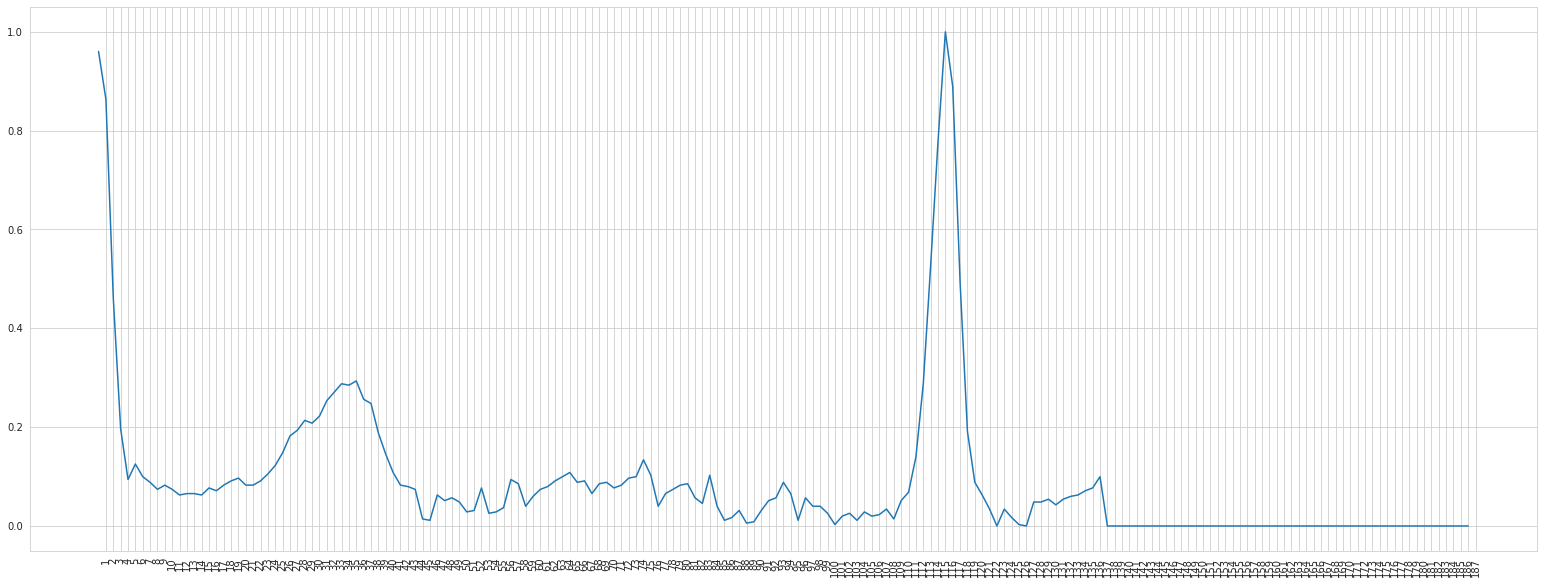

In [37]:
sns.set_style('whitegrid')
plt.figure(figsize=(27, 10))
plt.plot(data_train.iloc[0, 0:187])
plt.xticks(lst,lst,rotation=degrees)

In [40]:
# making the class labels for our dataset
data_1 = data_train[data_train.iloc[:,-1] == 1]
data_2 = data_train[data_train.iloc[:,-1] == 2]
data_3 = data_train[data_train.iloc[:,-1] == 3]
data_4 = data_train[data_train.iloc[:,-1] == 4]

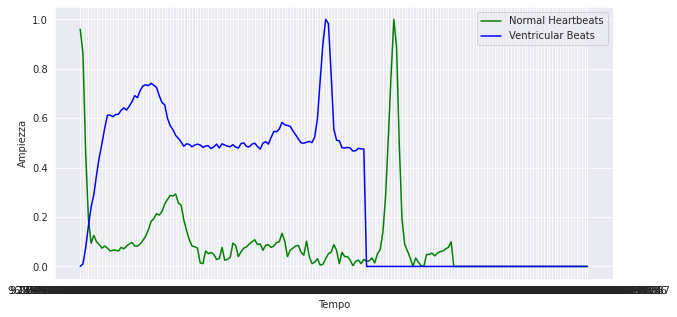

In [45]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_2.iloc[0, 0:187], color='blue', label='Ventricular Beats')
plt.xlabel('Tempo')
plt.ylabel('Ampiezza')
plt.legend()

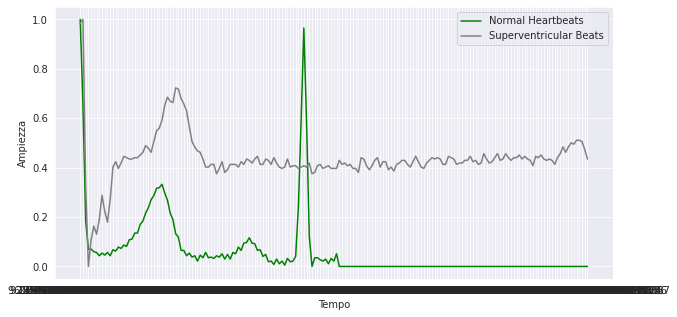

In [46]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[1, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_1.iloc[1, 0:187], color='grey', label='Superventricular Beats')
plt.xlabel('Tempo')
plt.ylabel('Ampiezza')
plt.legend()

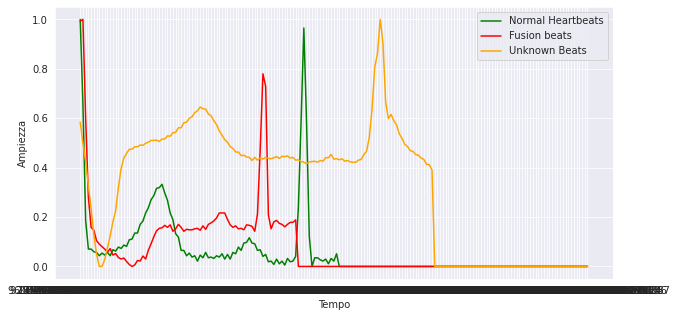

In [47]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[1, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_3.iloc[2, 0:187], color='red', label='Fusion beats')
plt.plot(data_4.iloc[2, 0:187], color='orange', label='Unknown Beats')
plt.xlabel('Tempo')
plt.ylabel('Ampiezza')
plt.legend()

Features Engineering

In [5]:
# LabelEncoder è una classe di utilità che aiuta a normalizzare le etichette in modo che contengano solo valori compresi tra 0 e n_classes-1.
encoder = LabelEncoder()
encoder.fit(y_train)
# trasform serve per valutare a quali "classi" appartiene ciascun valore.
y_train_enc= encoder.transform(y_train)
y_test_enc= encoder.transform(y_test)

y_train_cat= np_utils.to_categorical(y_train_enc)
y_test_cat= np_utils.to_categorical(y_test_enc)

In [6]:
y_train_f= pd.DataFrame(y_train_cat)
y_train_f.value_counts()

0    1    2    3    4  
1.0  0.0  0.0  0.0  0.0    72470
0.0  0.0  0.0  0.0  1.0     6431
          1.0  0.0  0.0     5788
     1.0  0.0  0.0  0.0     2223
     0.0  0.0  1.0  0.0      641
dtype: int64

In [7]:
y_test_f= pd.DataFrame(y_test_cat)
y_test_f.value_counts()

0    1    2    3    4  
1.0  0.0  0.0  0.0  0.0    18117
0.0  0.0  0.0  0.0  1.0     1608
          1.0  0.0  0.0     1448
     1.0  0.0  0.0  0.0      556
     0.0  0.0  1.0  0.0      162
dtype: int64

# **Neural network - classification ECG**

In [78]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[187]),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax'),
])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 187)              748       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 512)               96256     
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_16 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)              

In [79]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [80]:
history = model.fit(
    x_train, y_train_f,
    validation_data=(x_test, y_test_f),
    batch_size=3000,
    epochs=250,
    callbacks=[early_stopping],
    verbose=0,  
)

history_df = pd.DataFrame(history.history)

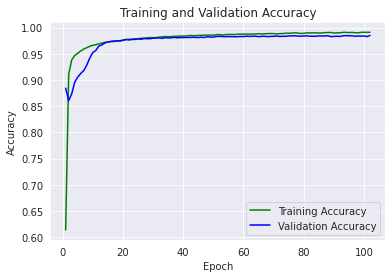

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [82]:
preds_1 = model.predict(x_test)
preds_1_rounded = np.round(preds_1)
y_test_fn = np.array(y_test_f)
# summary table --> Neural network accuracy
print(classification_report(np.argmax(y_test_fn, axis = 1), np.argmax(preds_1_rounded, axis = 1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18117
           1       0.94      0.71      0.81       556
           2       0.97      0.94      0.95      1448
           3       0.84      0.72      0.78       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21891
   macro avg       0.95      0.87      0.90     21891
weighted avg       0.98      0.98      0.98     21891



Normalized confusion matrix


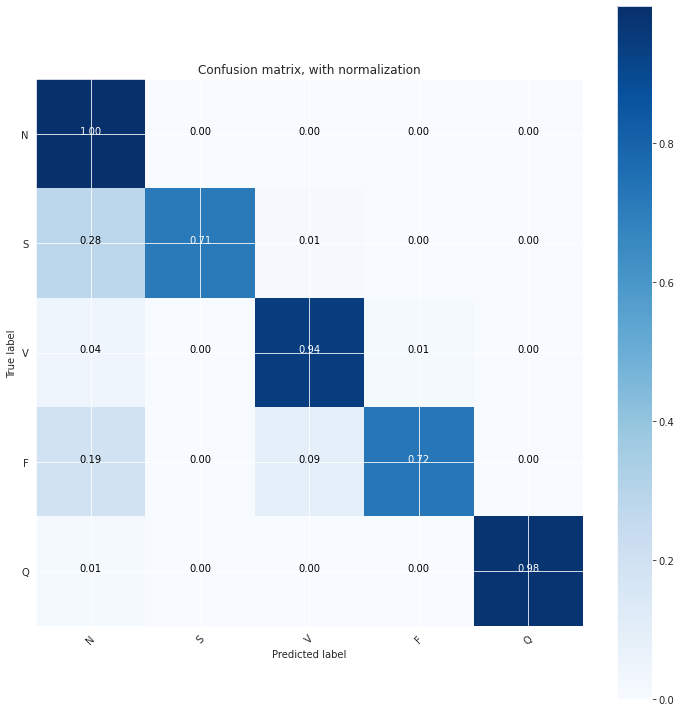

In [83]:
import itertools
def plot_confusion_matrix_new(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_fn.argmax(axis=1), preds_1_rounded.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix_new(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()